# Deterministic optimisation (using the fluid model)

Here we optimise over several deterministic objective functions evaluated using the fluid flow model. 

We start by giving an illustrative example of the dynamics of the unsheltered queue $u_t$ given by our fluid model, given inputs for $X_0, \mu_0$ and $\lambda_t, h_t, s_t$ for all $t \in \{1,...,T\}$ which we take directly from the simulation model of Singham et al (2023) (see right hand side of Fig 2 with 70% investment in housing and no decrease in shelter).

In [38]:
import json
import fluid_flow_model as fl
import simulation_model as sm
import deterministic_optimisation as do
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
import math
import numpy as np
import time

Arrival rates: 
[12.0, 13.2, 13.2, 11.88, 10.69]


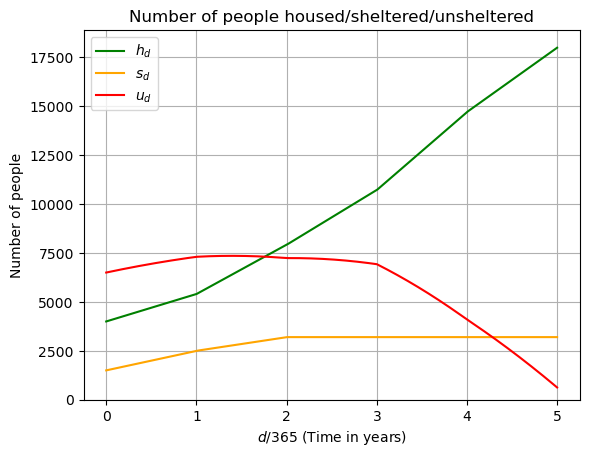

In [2]:
# Get data
with open('data_singham23.json') as json_file:
    data = json.load(json_file)

# 70% of investment in housing
investment = [x-data['initial_capacity']['housing'] for x in data['solution']['housing']]
data['solution']['housing'] = [data['initial_capacity']['housing'] + x*0.7 for x in investment]

# Don't decrease shelter (same in yrs 3,4,5 as 2)
stable_yrs = [3,4,5]
for yr in stable_yrs:
    data['solution']['shelter'][yr]=data['solution']['shelter'][2]

# changing arrival rate
delta = [0, 0.2, 0.1, 0, -0.1, -0.1] # changes specified in singham et al 2023
arrival_rates = [data['arrival_rates'][0]] # base level
for yr in range(1,len(delta)):
    arrival_rates.append(round(arrival_rates[-1]*(1+delta[yr]),2))
data['arrival_rates'] = arrival_rates[1:6] # remove the base level
print('Arrival rates: ')
print(data['arrival_rates'])

# Modelling horizonT_a is decision horizon, T_b is extra modelling horizon - here set to 0
T_a = 5
T_b = 0

# Modeling
model = fl.FluidFlowModel(data, data['solution'], T_a, T_b)
T = [i/365 for i in range((T_a+T_b)*365)]
model.analyse(T)

# Plotting
fig, ax = plt.subplots()
ymax = max(model.h_t + model.sh_t + model.unsh_t)
x = [t/365 for t in range((T_a+T_b)*365)]
ax.plot(x, model.h_t, color = 'green')
ax.plot(x, model.sh_t, color = 'orange')
ax.plot(x, model.unsh_t, color = 'red')
ax.set(xlabel="$d/365$ (Time in years)", ylabel='Number of people',
       title='Number of people housed/sheltered/unsheltered')
ax.legend(["$h_d$", "$s_d$", "$u_d$"], loc="upper left")
ax.grid()
ax.set_ylim(0,ymax*1.05)
plt.show()

####  $\Phi_0$ : linear penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t) + c*E[sh(t)]])
    # s.t. total budget constraint
    #      annual minimum build constraint

In [3]:
import deterministic_optimisation as do
import fluid_flow_model as fl

# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [10.0]*5 + [6.0]*5,
        'budget' : 200000000.0, # in dollars
        'costs_accomm' : {'housing' : 30000.0, 'shelter' : 10000.0}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'T_a' : 5, # in days: modelling and building
                    'T_b' : 5, # in days: extra modelling following all building
                    'model' : do.FluidModel}

------- Optimal solution -------
Housing capacity at end of each year: [7833.33, 8333.33, 8833.33, 9333.33, 9833.33]
Shelter capacity at the end of each year: [2000.0, 2500.0, 3000.0, 3500.0, 4000.0]
Optimal objective val: 6434.16


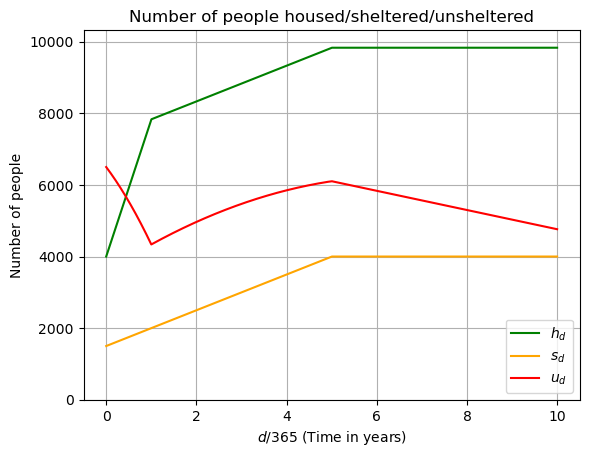

solved in 0.3662708529991505 seconds.


In [4]:
# Set up problem and solve
problem0 = do.Phi0(data, modeling_options, 'phi0', c=0.3)
tic = time.perf_counter()
problem0.solve('glpk')
toc = time.perf_counter()
print('solved in '+str(toc-tic) + ' seconds.')

####  $\Phi_1$ : quadratic penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint

A quadratic objective function discourages the spending of all surplus budget on one type of accommodation and balances the unshelterd and sheltered queues. We note here that: 

* **Shelter** quickly reduces the unsheltered queue, at the expense of a large **sheltered** population.
* **Housing** gives long-term relief to the system, with an initial large **unsheltered** population.  

------- Optimal solution -------
Housing capacity at end of each year: [7497.41, 7997.41, 8497.41, 8997.41, 9497.41]
Shelter capacity at the end of each year: [3007.78, 3507.78, 4007.78, 4507.78, 5007.78]
Optimal objective val: 32831088.19


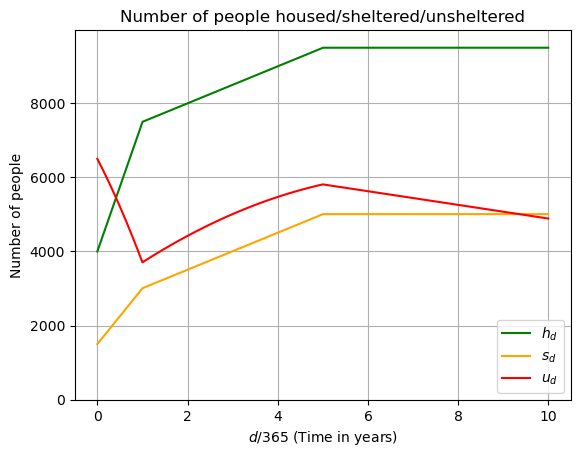

solved in 0.5749964660008118 seconds.


In [5]:
# Set up problem and solve
problem1 = do.Phi1(data, modeling_options, 'phi1', c=0.3)
tic = time.perf_counter()
problem1.solve('ipopt')
toc = time.perf_counter()
print('solved in '+str(toc-tic) + ' seconds.')

####  $\Phi_2$ : Add shape constraints
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      shape constraint on house building rate: positive and non-decreasing
    #      shape constraint on shelter building rate: positive and non-decreasing then negative. 

We here add shape constraints to reflect the fact that: 

* A five-year budget should be spread out across that horizon rather than being used predominantly in the first year.
* We would like the house building rate to at least stay the same over time, or even ramp up. 
* We would like to encourage a negative shelter build rate towards the end of the horizon to allow the 'conversion' of shelter to housing.

When optimising over the quadratic objective function, we find an optimal solution which has the following features: 

* A constant house building rate over the decision horizon. 
* An initial ramp up of shelter is able to bring the unshelterd queue down.
* Subsequent conversion of shelter to housing makes it affordable to build sufficient housing to obtain a service rate in the long run which is greater than the arrival rate of $2500 \text{ arrivals per year}$.
* The price to pay for conversion is an increased unsheltered population in the short term. 

------- Optimal solution -------
Housing capacity at end of each year: [5094.07, 6188.13, 7282.2, 8376.26, 9470.33]
Shelter capacity at the end of each year: [8148.31, 8148.31, 9040.33, 8371.21, 5089.01]
Optimal objective val: 42678726.81


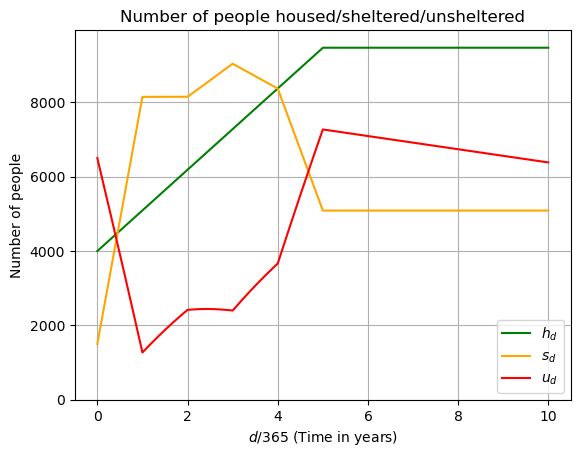

solved in 0.4471647179998399 seconds.


In [6]:
# Set up problem and solve
problem2 = do.Phi2(data, modeling_options, 'phi2', c=0.3, shelter_mode = 3)
tic = time.perf_counter()
problem2.solve('ipopt')
toc = time.perf_counter()
print('solved in '+str(toc-tic) + ' seconds.')

In [7]:
import pandas as pd
df = [['$\Phi_0$']+['Housing']+[str(problem0.problem.data['initial_capacity']['housing'])]+[str(int(round(problem0.h_opt[i],0))) + ' (' + '{:.01%}'.format(((problem0.h_opt[i]-problem0.h_opt[i-1])*problem0.problem.costs_accomm['housing'])/(problem0.problem.budget)) + ')' for i in range(1,len(problem0.h_opt))],
       ['']+['Shelter']+[str(problem0.problem.data['initial_capacity']['shelter'])]+[str(int(round(problem0.s_opt[i],0))) + ' (' + '{:.01%}'.format(((problem0.s_opt[i]-problem0.s_opt[i-1])*problem0.problem.costs_accomm['shelter'])/(problem0.problem.budget)) + ')' for i in range(1,len(problem0.s_opt))],
       ['$\Phi_1$']+['Housing']+[str(problem1.problem.data['initial_capacity']['housing'])]+[str(int(round(problem1.h_opt[i],0))) + ' (' + '{:.01%}'.format(((problem1.h_opt[i]-problem1.h_opt[i-1])*problem1.problem.costs_accomm['housing'])/(problem1.problem.budget)) + ')' for i in range(1,len(problem1.h_opt))],
       ['']+['Shelter']+[str(problem1.problem.data['initial_capacity']['shelter'])]+[str(int(round(problem1.s_opt[i],0))) + ' (' + '{:.01%}'.format(((problem1.s_opt[i]-problem1.s_opt[i-1])*problem1.problem.costs_accomm['shelter'])/(problem1.problem.budget)) + ')' for i in range(1,len(problem1.s_opt))],
       ['$\Phi_2$']+['Housing']+[str(problem2.problem.data['initial_capacity']['housing'])]+[str(int(round(problem2.h_opt[i],0))) + ' (' + '{:.01%}'.format(((problem2.h_opt[i]-problem2.h_opt[i-1])*problem2.problem.costs_accomm['housing'])/(problem2.problem.budget)) + ')' for i in range(1,len(problem2.h_opt))],
       ['']+['Shelter']+[str(problem2.problem.data['initial_capacity']['shelter'])]+[str(int(round(problem2.s_opt[i],0))) + ' (' + '{:.01%}'.format(((problem2.s_opt[i]-problem2.s_opt[i-1])*problem2.problem.costs_accomm['shelter'])/(problem2.problem.budget)) + ')' for i in range(1,len(problem2.s_opt))]]
df = pd.DataFrame(columns=['Problem','Building Type','Initial Capacity', 'Year 1','Year 2','Year 3','Year 4','Year 5'], data=df)
print(df.to_latex(index=False,

                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
))

\begin{tabular}{llllllll}
\toprule
Problem & Building Type & Initial Capacity & Year 1 & Year 2 & Year 3 & Year 4 & Year 5 \\
\midrule
$\Phi_0$ & Housing & 4000 & 7833 (57.5%) & 8333 (7.5%) & 8833 (7.5%) & 9333 (7.5%) & 9833 (7.5%) \\
 & Shelter & 1500 & 2000 (2.5%) & 2500 (2.5%) & 3000 (2.5%) & 3500 (2.5%) & 4000 (2.5%) \\
$\Phi_1$ & Housing & 4000 & 7497 (52.5%) & 7997 (7.5%) & 8497 (7.5%) & 8997 (7.5%) & 9497 (7.5%) \\
 & Shelter & 1500 & 3008 (7.5%) & 3508 (2.5%) & 4008 (2.5%) & 4508 (2.5%) & 5008 (2.5%) \\
$\Phi_2$ & Housing & 4000 & 5094 (16.4%) & 6188 (16.4%) & 7282 (16.4%) & 8376 (16.4%) & 9470 (16.4%) \\
 & Shelter & 1500 & 8148 (33.2%) & 8148 (0.0%) & 9040 (4.5%) & 8371 (-3.3%) & 5089 (-16.4%) \\
\bottomrule
\end{tabular}



<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_49794/2964386234.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = [['$\Phi_0$']+['Housing']+[str(problem0.problem.data['initial_capacity']['housing'])]+[str(int(round(problem0.h_opt[i],0))) + ' (' + '{:.01%}'.format(((problem0.h_opt[i]-problem0.h_opt[i-1])*problem0.problem.costs_accomm['housing'])/(problem0.problem.budget)) + ')' for i in range(1,len(problem0.h_opt))],
/tmp/ipykernel_49794/2964386234.py:4: SyntaxWarning: invalid escape sequence '\P'
  ['$\Phi_1$']+['Housing']+[str(problem1.problem.data['initial_capacity']['housing'])]+[str(int(round(problem1.h_opt[i],0))) + ' (' + '{:.01%}'.format(((problem1.h_opt[i]-problem1.h_opt[i-1])*problem1.problem.costs_accomm['

#### Comparing the unsheltered population for the 3 solutions

<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_49794/2040590651.py:21: SyntaxWarning: invalid escape sequence '\P'
  ax.legend(["Optimal solution to $\Phi_0$", "Optimal solution to $\Phi_1$", "Optimal solution to $\Phi_2$"], loc="lower right")
/tmp/ipykernel_49794/2040590651.py:21: SyntaxWarning: invalid escape sequence '\P'
  ax.legend(["Optimal solution to $\Phi_0$", "Optimal solution to $\Phi_1$", "Optimal solution to $\Phi_2$"], loc="lower right")
/tmp/ipykernel_49794/2040590651.py:21: SyntaxWarning: invalid escape sequence '\P'
  ax.legend(["Optimal solution to $\Phi_0$", "Optimal solution to $\Phi_1$", "Optimal solution to $\Phi_2$"], loc="lower right")


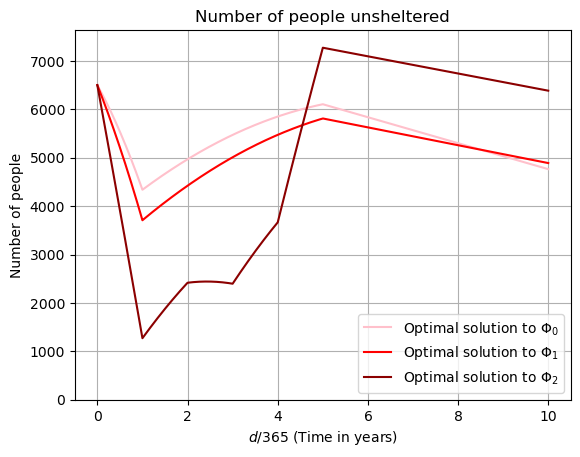

In [8]:
# Modeling
model0 = fl.FluidFlowModel(data, {'housing':problem0.h_opt,'shelter':problem0.s_opt}, modeling_options['T_a'], modeling_options['T_b'])
model1 = fl.FluidFlowModel(data, {'housing':problem1.h_opt,'shelter':problem1.s_opt}, modeling_options['T_a'], modeling_options['T_b'])
model2 = fl.FluidFlowModel(data, {'housing':problem2.h_opt,'shelter':problem2.s_opt}, modeling_options['T_a'], modeling_options['T_b'])

T = [i/365 for i in range((modeling_options['T_a']+modeling_options['T_b'])*365)]

model0.analyse(T)
model1.analyse(T)
model2.analyse(T)

# Plotting
fig, ax = plt.subplots()
ymax = max(model0.unsh_t + model1.unsh_t + model2.unsh_t)
x = [t/365 for t in range((modeling_options['T_a']+modeling_options['T_b'])*365)]
ax.plot(x, model0.unsh_t, color = 'pink')
ax.plot(x, model1.unsh_t, color = 'red')
ax.plot(x, model2.unsh_t, color = 'darkred')
ax.set(xlabel="$d/365$ (Time in years)", ylabel='Number of people',
       title='Number of people unsheltered')
ax.legend(["Optimal solution to $\Phi_0$", "Optimal solution to $\Phi_1$", "Optimal solution to $\Phi_2$"], loc="lower right")
ax.grid()
ax.set_ylim(0,ymax*1.05)
plt.show()

#### Checking the costs of optimal solutions

In [9]:
def cost(problem):
    costs = 0
    for t in range(problem.problem.horizon_decision):
        costs += (problem.h_opt[t+1]-problem.h_opt[t]) * problem.problem.costs_accomm['housing']
        costs += (problem.s_opt[t+1]-problem.s_opt[t]) * problem.problem.costs_accomm['shelter']
    return costs

print(cost(problem0))
print(cost(problem1))
print(cost(problem2))

200000000.00000018
200000000.00009772
200000000.0000971


### Review responses

The following additional analysis was performed following review comments. This analysis was not included in the paper itself. 

#### Exploring different weights for penalty on shelter

In [10]:
# Set up problem and solve
problems = []
models = []
weights = [0.2,0.4,0.6,0.8] 
for w in weights:
    problems.append(do.Phi2(data, modeling_options, 'phi2', c=w, shelter_mode = 3))
    problems[-1].solve('ipopt', print = False)
    models.append(problems[-1].problem.selected_model(problems[-1].problem.data, 
                                                      {'housing' : problems[-1].h_opt, 'shelter' : problems[-1].s_opt}, 
                                                      problems[-1].problem.horizon_decision, 
                                                      problems[-1].problem.horizon_extra_model))
    models[-1].analyse(problems[-1].problem.horizon_model)

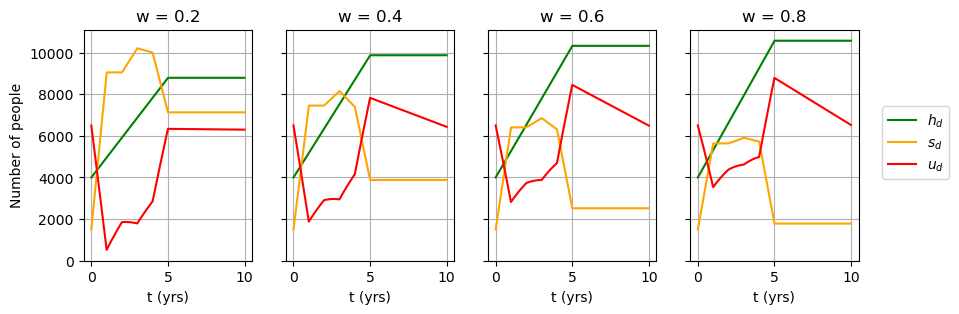

In [11]:
fig, axs = plt.subplots(1, 4,  figsize=(10, 3))
ymax = 0
for i in range(len(models)):
    ymax = max(ymax, max(models[i].model.h_t + models[i].model.sh_t + models[i].model.unsh_t))
    x = [j/365 for j in range(problems[i].problem.horizon_model*365)]
    axs[i].plot(x, models[i].model.h_t, color = 'green')
    axs[i].plot(x, models[i].model.sh_t, color = 'orange')
    axs[i].plot(x, models[i].model.unsh_t, color = 'red')
    axs[i].set(title = 'w = ' + str(weights[i]))
axs[i].legend(["$h_d$", "$s_d$", "$u_d$"], bbox_to_anchor=(1.1, 0.7))

# formatting
for ax in axs.flat:
    ax.set(xlabel='t (yrs)', ylabel='Number of people')
    ax.grid()
    ax.set_ylim(0, ymax*1.05)
    ax.label_outer()
plt.show()

#### Simulation of optimal solution

We simulate the optimal solution using a DES model. This DES model handles decommissioning differently to the queueing model (everyone waiting for a shelter may pass through it before shelter is removed from stock) - hence there is a difference between the plan for the shelter and actual shelter stocks within the simulation

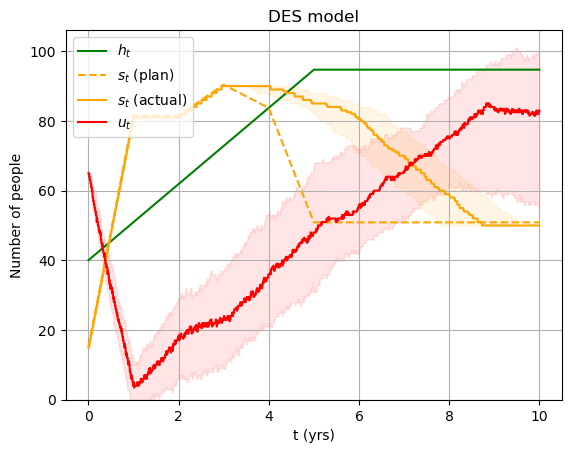

In [12]:
simulation_data = {"T_a":10-0.0027397260273972603,
 "T_b":0,
 "initial_capacity": {"housing": 40, "shelter": 15},
 "initial_demand": 120,
 "service_mean": {"housing": 4.0, "shelter": 0.0},
 "service_dist_triangle": {"low":0,"mid":5,"high":7},
 "arrival_rates" : [36.5]*5 + [(6/10)*36.5]*5,
 "solution": {'housing':[h/100 for h in problem2.h_opt[1:6]]+[problem2.h_opt[5]/100]*5,'shelter':[s/100 for s in problem2.s_opt[1:6]]+[problem2.s_opt[5]/100]*5},
 "max_in_system":500,
 "delta_t":1,
 "simulation_reps":100,
 "time_btwn_building":0.0027397260273972603,
 "simulation_build_time":0,
 "reentry_rate":0.0,
 "seed":12345}

with open('data_simulation.json') as json_file:
    data = json.load(json_file)

solution = data['solution']

s = sm.SimulationModel(simulation_data, simulation_data['solution'])
s.analyse()
s.plot()

### Review responses (second round)

The following additional analyses were performed following the second round of review comments. 

#### Sensitivity analysis

In [13]:
# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [10.0]*5 + [6.0]*5,
        'budget' : 200000000.0, # in dollars
        'costs_accomm' : {'housing' : 30000.0, 'shelter' : 10000.0}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'T_a' : 5, # in days: modelling and building
                    'T_b' : 5, # in days: extra modelling following all building
                    'model' : do.FluidModel}

# set up 
arrival = np.linspace(5, 13, 9)
service = np.linspace(3.5, 5.5, 9)

results_optimal_sol = np.zeros((len(arrival), len(service)))
results_stability = np.zeros((len(arrival), len(service)))
results_overloaded = np.zeros((len(arrival), len(service)))
results_unsh_model_ctrl = np.zeros((len(arrival), len(service)))
results_unsh_model = np.zeros((len(arrival), len(service)))
results_unsh_diff = np.zeros((len(arrival), len(service)))

# central scenario
data['arrival_rates'] = [10.0]*5 + [6.0]*5
data['service_mean']['housing'] = 4.0
problem_ctrl = do.Phi2(data, modeling_options, 'phi2', c=0.3, shelter_mode = 3)
problem_ctrl.solve('ipopt', print = False)

# collect data
for i, arr in enumerate(arrival):
    for j, svc in enumerate(service):
        # data update
        data['arrival_rates'] = [10.0]*5 + [arr]*5
        data['service_mean']['housing'] = svc

        # solve problem with this arrival / service 
        problem = do.Phi2(data, modeling_options, 'phi2', c=0.3, shelter_mode = 3)
        problem.solve('ipopt', print = False)
        houses_built = problem.h_opt[-1] - data['initial_capacity']['housing']
        shelters_built = problem.s_opt[-1] - data['initial_capacity']['shelter']         
        
        # how does the optimal solution look
        model = fl.FluidFlowModel(data, {'housing':problem.h_opt,'shelter':problem.s_opt}, modeling_options['T_a'], modeling_options['T_b'])
        T = [i/365 for i in range((modeling_options['T_a']+modeling_options['T_b'])*365)]
        model.analyse(T)
        
        # how does solution to central scenario fare with this data
        model_ctrl = fl.FluidFlowModel(data, {'housing':problem_ctrl.h_opt,'shelter':problem_ctrl.s_opt}, modeling_options['T_a'], modeling_options['T_b'])
        T = [i/365 for i in range((modeling_options['T_a']+modeling_options['T_b'])*365)]
        model_ctrl.analyse(T)
        
        results_optimal_sol[i,j] = problem.instance.OBJ()
        results_stability[i,j] = (problem.h_opt[-1]/svc > arr*365)
        results_overloaded[i,j] = sum([x <= 0 for x in model.unsh_t])>0
        if results_overloaded[i,j]:
            print('assumps violated')
            results_unsh_model_ctrl[i,j] = 0
            results_unsh_model[i,j] = 0
            results_unsh_diff[i,j] = 0
        else:
            results_unsh_model_ctrl[i,j] = np.mean(model_ctrl.unsh_t)
            results_unsh_model[i,j] = np.mean(model.unsh_t)
            results_unsh_diff[i,j] = max(0,(np.mean(model_ctrl.unsh_t) - np.mean(model.unsh_t))/np.mean(model_ctrl.unsh_t))
            #results_unsh_diff[i,j] = (model_ctrl.unsh_t[-1] - model.unsh_t[-1])/model_ctrl.unsh_t[-1]
    print('done ' + str(i))

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8


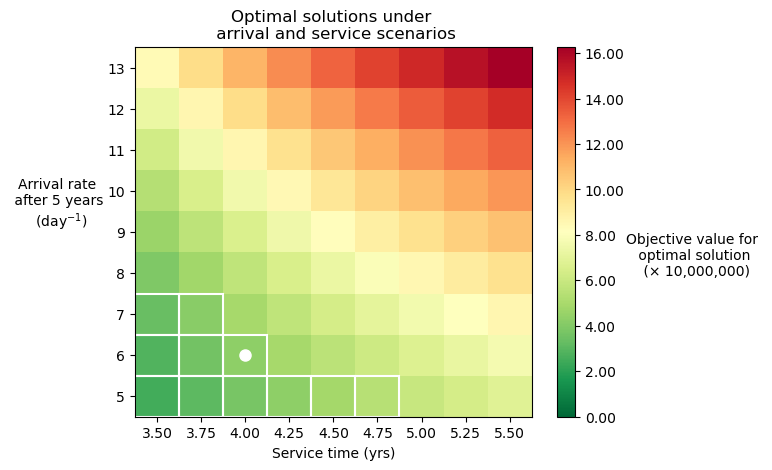

In [14]:
fig, ax = plt.subplots()

# If service and arrival are centers, compute edges
service_edges = np.concatenate((
    [service[0] - (service[1] - service[0]) / 2],
    service[:-1] + np.diff(service) / 2,
    [service[-1] + (service[-1] - service[-2]) / 2]
))

arrival_edges = np.concatenate((
    [arrival[0] - (arrival[1] - arrival[0]) / 2],
    arrival[:-1] + np.diff(arrival) / 2,
    [arrival[-1] + (arrival[-1] - arrival[-2]) / 2]
))

# Plot with pcolormesh
c = ax.pcolormesh(service_edges, arrival_edges, results_optimal_sol,
                  shading='auto', vmin=0, cmap = 'RdYlGn_r')

# Axes
ax.set_xlabel('Service time (yrs)')
ax.set_ylabel('Arrival rate \n after 5 years \n (day$^{-1}$)', rotation=0, labelpad=35)

# color bar
cb = fig.colorbar(c, ax=ax, label='Proportion housing')

# Remove scientific notation and add custom scale text
scale_factor = 1e7
cb.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f'{val/scale_factor:.2f}'))
cb.set_label(f'Objective value for \n optimal solution \n (× {scale_factor:,.0f})', rotation=0, labelpad=50)
cb.ax.yaxis.set_label_position('right')  # Position label near ticks
cb.ax.yaxis.set_ticks_position('right')  # Keep ticks on left if desired

# White dot for the scenario we analysed in previous sections. 
ax.plot(4.0, 6.0, marker='o', color='white', markersize=8)

# Overlay white boxes
for i in range(results_stability.shape[0]):      # loop over arrival index
    for j in range(results_stability.shape[1]):  # loop over service index
        if results_stability[i, j]:
            rect = patches.Rectangle(
                (service_edges[j], arrival_edges[i]),  # bottom-left corner
                service_edges[j+1] - service_edges[j], # width
                arrival_edges[i+1] - arrival_edges[i], # height
                linewidth=1.5,
                edgecolor='white',
                facecolor='none'
            )
            ax.add_patch(rect)

# Title
ax.set_title('Optimal solutions under \n arrival and service scenarios')

plt.savefig('sensitivity_grid.png', dpi=1000, bbox_inches='tight')

plt.show()

In [15]:
# Set up problem and solve
problems = []
models = []
arrival_rates = [5.0,13.0]
service_means = [3.5,5.5]
for arr in arrival_rates:
    for svc in service_means:
        data['arrival_rates'] = [10.0]*5 + [arr]*5
        data['service_mean']['housing'] = svc
        problems.append(do.Phi2(data, modeling_options, 'phi2', c=0.3, shelter_mode = 3))
        problems[-1].solve('ipopt', print = False)
        models.append(problems[-1].problem.selected_model(problems[-1].problem.data, 
                                                          {'housing' : problems[-1].h_opt, 'shelter' : problems[-1].s_opt}, 
                                                          problems[-1].problem.horizon_decision, 
                                                          problems[-1].problem.horizon_extra_model))
        models[-1].analyse(problems[-1].problem.horizon_model)

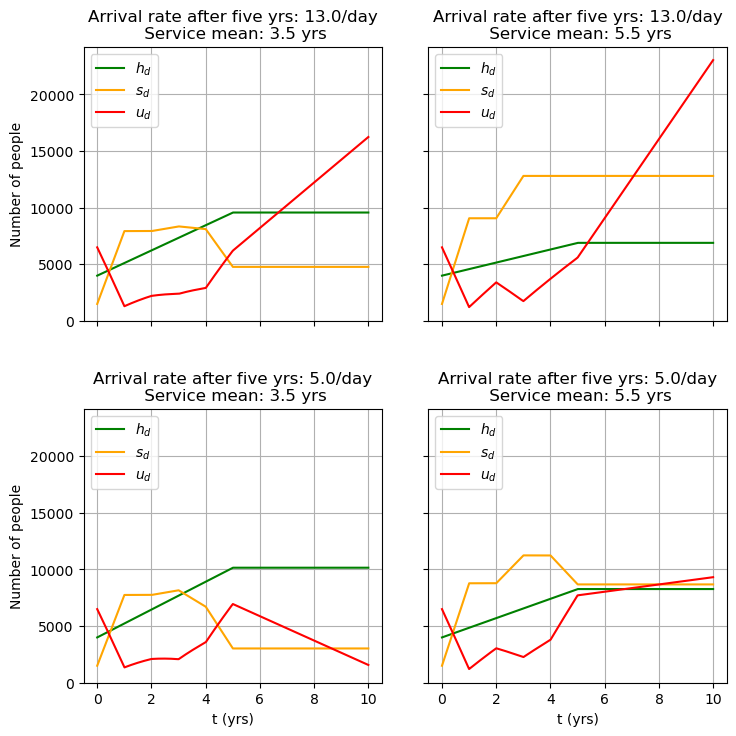

In [16]:
fig, axs = plt.subplots(2, 2,  figsize=(8, 8))
ymax = 0
for i in range(len(arrival_rates)):
    for j in range(len(service_means)):# Fill each subplot
        k=2*i+j # index
        ymax = max(ymax, max(models[k].model.h_t + models[k].model.sh_t + models[k].model.unsh_t))
        x = [j/365 for j in range(problems[k].problem.horizon_model*365)]
        axs[1-i,j].plot(x, models[k].model.h_t, color = 'green')
        axs[1-i,j].plot(x, models[k].model.sh_t, color = 'orange')
        axs[1-i,j].plot(x, models[k].model.unsh_t, color = 'red')
        axs[1-i,j].set(title = 'Arrival rate after five yrs: ' + str((arrival_rates[i])) + '/day' '\n Service mean: ' + str((service_means[j])) + ' yrs')
        axs[1-i,j].legend(["$h_d$", "$s_d$", "$u_d$"], loc = 'upper left')

# formatting
for ax in axs.flat:
    ax.set(xlabel='t (yrs)', ylabel='Number of people')
    ax.grid()
    ax.set_ylim(0, ymax*1.05)
    ax.label_outer()

plt.tight_layout(pad=3.0)

plt.savefig('sensitivity_four_solutions.png', dpi=1000, bbox_inches='tight')

plt.show()

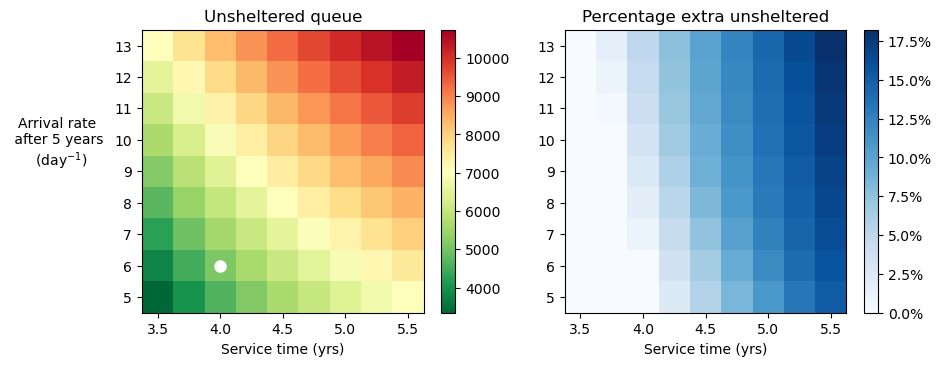

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4.1))

# Plot with pcolormesh
lightReds = ListedColormap(plt.cm.Reds(np.linspace(0, 0.6, 256)))
c0 = axs[0].pcolormesh(service_edges, arrival_edges, results_unsh_model_ctrl,
                       shading='auto', cmap='RdYlGn_r')
c1 = axs[1].pcolormesh(service_edges, arrival_edges, results_unsh_diff,
                       shading='auto', cmap='Blues')

# White dot for the scenario we analysed in previous sections. 
axs[0].plot(4.0, 6.0, marker='o', color='white', markersize=8)

# Axes formatting
axs[0].set_xlabel('Service time (yrs)')
axs[0].set_ylabel('Arrival rate \n after 5 years \n (day$^{-1}$)',
                  rotation=0, labelpad=40)

axs[1].set_xlabel('Service time (yrs)')
axs[1].set_ylabel('')  # No label, but ticks remain

# Color bars
cb0 = fig.colorbar(c0, ax=axs[0])
cb1 = fig.colorbar(c1, ax=axs[1],format=PercentFormatter(xmax=1.0))

# Titles
axs[0].set_title('Unsheltered queue')
axs[1].set_title('Percentage extra unsheltered')

# Adjust padding between subplots
plt.subplots_adjust(wspace=0.2, top=0.8)  # wspace = horizontal gap

plt.savefig('sensitivity_extra_unsheltered.png', dpi=1000, bbox_inches='tight')

plt.show()